In [1]:
import ee
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import pandas as pd
import rasterio as rio
from rasterio.plot import show

from src.data import mtbs
from src.visualization import ee_viz
from src.data import gedi_loader

import seaborn as sns
sns.set_theme()

import importlib
importlib.reload(mtbs)
importlib.reload(ee_viz)

<module 'src.visualization.ee_viz' from '/home/jk871/fire-regen/src/visualization/ee_viz.py'>

### Initialize Earth Engine

In [ ]:
ee.Authenticate()

In [2]:
ee.Initialize()

### Get regions of interest

In [3]:
# Fetch simplified regions of interest - to avoid processing problems with really complicated shapes.
seki = gpd.read_file("../../data/shapefiles/seki_convex_hull.shp")
sierras = gpd.read_file("../../data/shapefiles/sierras_convex_hull.shp")

In [ ]:
gedi_sierras = pd.read_csv(f'/maps/fire-regen/data/sierras_matched_all.csv', index_col=0)
gedi_seki = pd.read_csv(f'/maps/fire-regen/data/seki_matched_all.csv', index_col=0)

In [ ]:
gedi_sierras = gpd.GeoDataFrame(gedi_sierras, geometry=gpd.points_from_xy(gedi_sierras.lon_lowestmode, gedi_sierras.lat_lowestmode), crs=4326)

In [ ]:
gedi_sierras_gpd = gpd.GeoDataFrame(gedi_sierras, geometry=gpd.points_from_xy(gedi_sierras.lon_lowestmode, gedi_sierras.lat_lowestmode), crs=4326)

In [ ]:
type(gedi_sierras.geometry)

In [ ]:
raster = rio.open('/maps/fire-regen/data/rasters/burn_data_sierras.tif')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# transform rasterio plot to real world coords
extent=[raster.bounds[0], raster.bounds[2], raster.bounds[1], raster.bounds[3]]
ax = rio.plot.show(raster, extent=extent, ax=ax, cmap='inferno')

gedi_sierras_gpd.head(1000).plot(ax=ax)

In [ ]:
gedi_burn_gpd_no_match = gedi_sierras_gpd[gedi_sierras_gpd.burn_year_mean == 0]
gedi_burn_match = gedi_sierras_gpd[gedi_sierras_gpd.burn_year_mean != 0]

In [ ]:
gedi_burn_perfect_match = gedi_burn_match[(gedi_burn_match.burn_year_std == 0) & (gedi_burn_match.burn_severity_std == 0)]
gedi_burn_imperfect_match = gedi_burn_match[(gedi_burn_match.burn_year_std == 0)]

In [ ]:
gedi_burn_gpd_no_match.shape[0]
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.histplot(gedi_burn_gpd_no_match, x='pft_class')

### Get Fire Perimeters

In [4]:
layers = fiona.listlayers('../../data/fire_perimeters.gdb/')
layers

['firep21_2', 'rxburn21_2', 'Non_RXFire_Legacy13_2']

First layer, 'firep21_2' is fire perimeters.

Second layer, 'rxburn21_2' are prescribed burns.

Third layer, 'Non_RXFire_Legacy13_2' seem to be other treatment types.

In [5]:
gdf_fire_perimeters = gpd.read_file('../../data/fire_perimeters.gdb/', layer=layers[0])

In [6]:
# Get only fire perimeters in 2020 and 2021 - for these we have GEDI data before and after the fires. And we know those were the extreme fire years.
gdf_fire_perimeters = gdf_fire_perimeters[gdf_fire_perimeters.YEAR_.isin(['2020', '2021'])]

In [7]:
firep = gdf_fire_perimeters.to_crs(4326)

In [8]:
print(f'Total number of fires in California in 2020 and 2021 is {firep.shape[0]}')
# Get fires that are completely within Sierras.
sierra_fire_perimeters = firep.sjoin(sierras, how="inner", predicate="within")
print(f'Total number of fires in the Sierras in 2020 and 2021 is {sierra_fire_perimeters.shape[0]}')

seki_fire_perimeters = firep.sjoin(seki, how="inner", predicate="within")
print(f'Total number of fires in SEKI in 2020 and 2021 is {seki_fire_perimeters.shape[0]}')

Total number of fires in California in 2020 and 2021 is 878
Total number of fires in the Sierras in 2020 and 2021 is 248
Total number of fires in SEKI in 2020 and 2021 is 5


In [9]:
firep.columns

Index(['YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM',
       'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'COMMENTS', 'REPORT_AC',
       'GIS_ACRES', 'C_METHOD', 'OBJECTIVE', 'FIRE_NUM', 'Shape_Length',
       'Shape_Area', 'COMPLEX_NAME', 'COMPLEX_INCNUM', 'geometry'],
      dtype='object')

In [10]:
sierra_fire_perimeters.sort_values('Shape_Area', ascending=False).head(20).FIRE_NAME

21674               DIXIE
241                 CREEK
236         NORTH COMPLEX
21594              CALDOR
237                CASTLE
21575               SUGAR
21645               WINDY
21424         KNP Complex
340      W-5 COLD SPRINGS
21660            TAMARACK
231              LOYALTON
232                 SHEEP
336                 SLINK
21623              FRENCH
424                  GOLD
325         MOUNTAIN VIEW
318              BACCARAT
21648               RIVER
295                   HOG
21595             WALKERS
Name: FIRE_NAME, dtype: object

## Dixie Fire

In [16]:
dixie = sierra_fire_perimeters[sierra_fire_perimeters.FIRE_NAME=='DIXIE']
dixie[['FIRE_NAME', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'GIS_ACRES', 'Shape_Area']]

FIRE_NAME                 ALARM_DATE                  CONT_DATE  CAUSE  \
21674     DIXIE  2021-07-14T00:00:00+00:00  2021-10-25T00:00:00+00:00   11.0   

         GIS_ACRES    Shape_Area  
21674  963405.4375  3.898763e+09

In [18]:
dixie = dixie.drop(columns=['index_right'])

In [20]:
gedi_dixie = gedi_loader.get_gedi_shots(dixie.geometry)
gedi_dixie

2023-05-01 17:31:10,956 INFO: Loading Level 4a GEDI shots for period 2019-2023 in this geometry [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:20]


/home/jk871/fire-regen/src/data/gedi_database.py:77: SAWarning: Did not recognize type 'geometry' of column 'geometry'
  col["name"] for col in self.inspector.get_columns(table_name)
/home/jk871/fire-regen/src/data/gedi_database.py:77: SAWarning: Did not recognize type 'geometry' of column 'geom_4326'
  col["name"] for col in self.inspector.get_columns(table_name)


2023-05-01 17:35:17,598 INFO: Number of GEDI shots found: 351665 [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:58]


shot_number                     absolute_time  lon_lowestmode  \
33      103500200300424858  2020-10-10 02:23:38.135324+01:00     -121.239147   
34      103500200300424859  2020-10-10 02:23:38.143588+01:00     -121.238629   
35      103500200300424860  2020-10-10 02:23:38.151851+01:00     -121.238112   
36      103500200300424863  2020-10-10 02:23:38.176643+01:00     -121.236565   
38      103500200300424867  2020-10-10 02:23:38.209700+01:00     -121.234483   
...                    ...                               ...             ...   
825516  157480600300616187  2021-09-23 08:36:13.847577+01:00     -121.236228   
825518  157480600300616189  2021-09-23 08:36:13.864105+01:00     -121.235158   
825519  157480800300187974  2021-09-23 08:36:14.252513+01:00     -121.238585   
825520  157480800300187982  2021-09-23 08:36:14.318625+01:00     -121.234294   
825525  198931100200109615  2022-06-17 16:28:19.803138+01:00     -121.234682   

        lat_lowestmode        agbd  agbd_pi_lower  agbd_pi_upper    agbd_se  \
33           40.031289   59.130062       4.869074     173.517807  11.101396   
34           40.030978  103.549484      22.028751     245.184662  11.099120   
35           40.030668  123.195442      31.546926     274.963470  11.100060   
36           40.029737  113.858910      26.915934     260.915619  11.098979   
38           40.028491   55.092758       3.759402     166.564346  11.103513   
...                ...         ...            ...            ...        ...   
825516       40.526001   78.351288      11.347720     205.481201  11.101313   
825518       40.525381   66.218155       7.045688     185.518997  11.101691   
825519       40.517687   87.923668      15.051414     221.233200  11.158718   
825520       40.515200  149.009155      45.158447     313.072601  11.117267   
825525       40.528280   61.715912       5.630513     177.929581  11.101672   

       beam_type  sensitivity  pft_class                     geometry  
33      coverage     0.973783          1  POINT (-121.23915 40.03129)  
34      coverage     0.959067          1  POINT (-121.23863 40.03098)  
35      coverage     0.971576          1  POINT (-121.23811 40.03067)  
36      coverage     0.963314          1  POINT (-121.23656 40.02974)  
38      coverage     0.969379          1  POINT (-121.23448 40.02849)  
...          ...          ...        ...                          ...  
825516      full     0.959159          1  POINT (-121.23623 40.52600)  
825518      full     0.953592          1  POINT (-121.23516 40.52538)  
825519      full     0.961390          1  POINT (-121.23858 40.51769)  
825520      full     0.985166          1  POINT (-121.23429 40.51520)  
825525      full     0.956397          1  POINT (-121.23468 40.52828)  

[351665 rows x 12 columns]

In [23]:
from src.data import shape_processor
gedi_dixie_2 = gedi_loader.get_gedi_shots(shape_processor.get_convex_hull(dixie.geometry).geometry)
gedi_dixie_2

2023-05-01 17:37:19,246 INFO: Loading Level 4a GEDI shots for period 2019-2023 in this geometry [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:20]


/home/jk871/fire-regen/src/data/gedi_database.py:77: SAWarning: Did not recognize type 'geometry' of column 'geometry'
  col["name"] for col in self.inspector.get_columns(table_name)
/home/jk871/fire-regen/src/data/gedi_database.py:77: SAWarning: Did not recognize type 'geometry' of column 'geom_4326'
  col["name"] for col in self.inspector.get_columns(table_name)


2023-05-01 17:37:53,548 INFO: Number of GEDI shots found: 649365 [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:58]


shot_number                     absolute_time  lon_lowestmode  \
33       103500200300424858  2020-10-10 02:23:38.135324+01:00     -121.239147   
34       103500200300424859  2020-10-10 02:23:38.143588+01:00     -121.238629   
35       103500200300424860  2020-10-10 02:23:38.151851+01:00     -121.238112   
36       103500200300424863  2020-10-10 02:23:38.176643+01:00     -121.236565   
38       103500200300424867  2020-10-10 02:23:38.209700+01:00     -121.234483   
...                     ...                               ...             ...   
1558717   47331100200078833  2019-10-13 19:13:01.610473+01:00     -120.394859   
1558718   47331100200078834  2019-10-13 19:13:01.618737+01:00     -120.394325   
1558719   47331100200078835  2019-10-13 19:13:01.627001+01:00     -120.393794   
1558720   47331100200078836  2019-10-13 19:13:01.635265+01:00     -120.393262   
1558721   47331100200078837  2019-10-13 19:13:01.643529+01:00     -120.392732   

         lat_lowestmode        agbd  agbd_pi_lower  agbd_pi_upper    agbd_se  \
33            40.031289   59.130062       4.869074     173.517807  11.101396   
34            40.030978  103.549484      22.028751     245.184662  11.099120   
35            40.030668  123.195442      31.546926     274.963470  11.100060   
36            40.029737  113.858910      26.915934     260.915619  11.098979   
38            40.028491   55.092758       3.759402     166.564346  11.103513   
...                 ...         ...            ...            ...        ...   
1558717       40.093356  238.267426     155.402985     338.771729   3.190897   
1558718       40.093672   18.002489       1.881916      50.609547   2.982255   
1558719       40.093987    6.985928   -9999.000000      30.446772   2.989871   
1558720       40.094301    5.214613   -9999.000000      26.623156   2.992872   
1558721       40.094615    2.750601   -9999.000000      20.591175   2.999213   

        beam_type  sensitivity  pft_class                     geometry  
33       coverage     0.973783          1  POINT (-121.23915 40.03129)  
34       coverage     0.959067          1  POINT (-121.23863 40.03098)  
35       coverage     0.971576          1  POINT (-121.23811 40.03067)  
36       coverage     0.963314          1  POINT (-121.23656 40.02974)  
38       coverage     0.969379          1  POINT (-121.23448 40.02849)  
...           ...          ...        ...                          ...  
1558717      full     0.975842          6  POINT (-120.39486 40.09336)  
1558718      full     0.962248          6  POINT (-120.39433 40.09367)  
1558719      full     0.970579          6  POINT (-120.39379 40.09399)  
1558720      full     0.973688          6  POINT (-120.39326 40.09430)  
1558721      full     0.979171          6  POINT (-120.39273 40.09462)  

[649365 rows x 12 columns]

In [22]:
shape_processor.get_convex_hull(dixie.geometry)

geometry
0  POLYGON ((-121.39414 39.86018, -121.39433 39.8...

In [ ]:
# Get GEDI data for dixie fire.
gedi_dixie = gedi_sierras.sjoin(dixie, how="inner", predicate="intersects")
gedi_dixie

In [ ]:
gedi_dixie = gedi_sierras.within(dixie.loc[0, 'geometry'])
gedi_dixie

In [38]:
severity = mtbs.get_burn_severity_data_for_year(2021)

In [39]:
severity

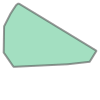

In [29]:
shape_processor.get_convex_hull(dixie.geometry).geometry.iloc[0]

In [46]:
ee_viz.viz_burn_severity(severity, shape_processor.get_convex_hull(dixie.geometry).geometry.iloc[0], ['burn_severity', 'burn_year'])

{'max': {'burn_severity': None, 'burn_year': None}, 'mean': {'burn_severity': None, 'burn_year': None}, 'min': {'burn_severity': None, 'burn_year': None}, 'std': {'burn_severity': None, 'burn_year': None}, 'sum': {'burn_severity': 0, 'burn_year': 0}}


ValueError: The provided min value must be scalar type.

<AxesSubplot: >

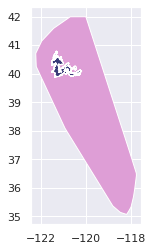

In [48]:
dixie = sierra_fire_perimeters[sierra_fire_perimeters.FIRE_NAME=='DIXIE'].overlay(sierras, how="union")
dixie.plot(cmap='tab20b')

In [ ]:
dixie

In [49]:
sierra_fire_perimeters[sierra_fire_perimeters.FIRE_NAME=='DIXIE'].geometry.explore()

## Creek Fire

In [11]:
creek = sierra_fire_perimeters[sierra_fire_perimeters.FIRE_NAME=='CREEK']
creek[['FIRE_NAME', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'GIS_ACRES', 'Shape_Area']]

FIRE_NAME                 ALARM_DATE                  CONT_DATE  CAUSE  \
241     CREEK  2020-09-04T00:00:00+00:00  2020-12-24T00:00:00+00:00   14.0   

        GIS_ACRES    Shape_Area  
241  379842.40625  1.537168e+09

<AxesSubplot: >

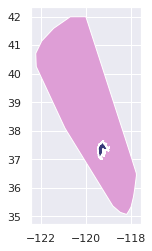

In [54]:
creek.overlay(sierras, how="union").plot(cmap='tab20b')

In [55]:
sierra_fire_perimeters[sierra_fire_perimeters.FIRE_NAME=='CREEK'].geometry.explore()

In [12]:
severity = mtbs.get_burn_severity_data_for_year(2020)

In [15]:
from src.data import shape_processor
ee_viz.viz_burn_severity(severity, shape_processor.get_convex_hull(creek.geometry).geometry.iloc[0], ['burn_severity'])

{'max': {'burn_severity': 6, 'burn_year': 2020}, 'mean': {'burn_severity': 2.524398022006092, 'burn_year': 2020}, 'min': {'burn_severity': 1, 'burn_year': 2020}, 'std': {'burn_severity': 0.9053070636083459, 'burn_year': 0}, 'sum': {'burn_severity': 4356041.6509803925, 'burn_year': 3485664328}}


Map(center=[37.3271746211198, -119.24194382373152], controls=(WidgetControl(options=['position', 'transparent_…

In [16]:
gedi_creek = gedi_loader.get_gedi_shots(creek.geometry)

2023-05-01 18:27:43,531 INFO: Loading Level 4a GEDI shots for period 2019-2023 in this geometry [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:20]
2023-05-01 18:28:15,089 INFO: Number of GEDI shots found: 110015 [in get_gedi_shots at /home/jk871/fire-regen/src/data/gedi_loader.py:58]


NameError: name 'creek_dixie' is not defined

In [18]:
gedi_creek = gpd.GeoDataFrame(gedi_creek, geometry=gpd.points_from_xy(gedi_creek.lon_lowestmode, gedi_creek.lat_lowestmode), crs=4326)

In [22]:
gedi_creek.columns

Index(['shot_number', 'absolute_time', 'lon_lowestmode', 'lat_lowestmode',
       'agbd', 'agbd_pi_lower', 'agbd_pi_upper', 'agbd_se', 'beam_type',
       'sensitivity', 'pft_class', 'geometry'],
      dtype='object')

In [29]:
creek

YEAR_ STATE AGENCY UNIT_ID FIRE_NAME   INC_NUM                 ALARM_DATE  \
241  2020    CA    USF     SNF     CREEK  00001391  2020-09-04T00:00:00+00:00   

                     CONT_DATE  CAUSE                              COMMENTS  \
241  2020-12-24T00:00:00+00:00   14.0  33CBB9DC-6983-4F47-B821-9C9A6CAC381D   

     ...  C_METHOD  OBJECTIVE  FIRE_NUM   Shape_Length    Shape_Area  \
241  ...       8.0        1.0      None  818087.845138  1.537168e+09   

     COMPLEX_NAME  COMPLEX_INCNUM  \
241          None            None   

                                              geometry index_right FID  
241  MULTIPOLYGON (((-119.18131 37.09620, -119.1813...           0   0  

[1 rows x 22 columns]

In [32]:
alarm_date = pd.to_datetime(creek.loc[241, 'ALARM_DATE'])

In [51]:
cont_date = pd.to_datetime(creek.loc[241, 'CONT_DATE'])

In [33]:
alarm_date

Timestamp('2020-09-04 00:00:00+0000', tz='UTC')

In [34]:
gedi_creek_before = gedi_creek[gedi_creek.absolute_time < alarm_date]

In [52]:
gedi_creek_after = gedi_creek[gedi_creek.absolute_time > cont_date]

In [37]:
gedi_creek_before[gedi_creek_before.pft_class==1]

shot_number                     absolute_time  lon_lowestmode  \
32      88970300200080846  2020-07-08 08:31:34.139063+01:00     -119.076509   
35      88970300200080851  2020-07-08 08:31:34.180383+01:00     -119.074045   
39      88970500200080811  2020-07-08 08:31:34.626648+01:00     -119.063543   
40      88970500200080812  2020-07-08 08:31:34.634914+01:00     -119.063055   
41      88970500200080815  2020-07-08 08:31:34.659712+01:00     -119.061597   
...                   ...                               ...             ...   
229887  22790300300216424  2019-05-08 16:35:54.908676+01:00     -119.427679   
229888  22790300300216425  2019-05-08 16:35:54.916940+01:00     -119.427184   
229889  22790300300216426  2019-05-08 16:35:54.925204+01:00     -119.426690   
229890  22790300300216427  2019-05-08 16:35:54.933468+01:00     -119.426195   
230000  22790500300216227  2019-05-08 16:35:54.784699+01:00     -119.461637   

        lat_lowestmode        agbd  agbd_pi_lower  agbd_pi_upper    agbd_se  \
32           37.322262  198.413193      73.988052     382.993256  11.106586   
35           37.323977   44.767944       1.457744     148.216003  11.103441   
39           37.322730   54.071041       3.438805     165.179077  11.165835   
40           37.323069  143.046692      41.937157     304.311859  11.106715   
41           37.324078   68.086197       7.575887     189.074600  11.166255   
...                ...         ...            ...            ...        ...   
229887       37.386855  126.496910      33.163212     280.074188  11.122966   
229888       37.386516  496.112640     281.694672     770.806885  11.129007   
229889       37.386177   34.543156       0.154073     129.098755  11.108734   
229890       37.385838   62.589233       5.853969     179.645065  11.137176   
230000       37.400117   22.677456   -9999.000000     104.993454  11.107620   

       beam_type  sensitivity  pft_class                     geometry  
32      coverage     0.973971          1  POINT (-119.07651 37.32226)  
35      coverage     0.975830          1  POINT (-119.07405 37.32398)  
39          full     0.963817          1  POINT (-119.06354 37.32273)  
40          full     0.989030          1  POINT (-119.06305 37.32307)  
41          full     0.971689          1  POINT (-119.06160 37.32408)  
...          ...          ...        ...                          ...  
229887  coverage     0.972174          1  POINT (-119.42768 37.38686)  
229888  coverage     0.974600          1  POINT (-119.42718 37.38652)  
229889  coverage     0.963801          1  POINT (-119.42669 37.38618)  
229890  coverage     0.980210          1  POINT (-119.42619 37.38584)  
230000      full     0.961019          1  POINT (-119.46164 37.40012)  

[40510 rows x 12 columns]

In [53]:
gedi_creek_after[gedi_creek_after.pft_class==1]

shot_number                     absolute_time  lon_lowestmode  \
0       154280500300290322  2021-09-02 16:59:13.930352+01:00     -119.073946   
1       154280500300290324  2021-09-02 16:59:13.946884+01:00     -119.072975   
2       154280500300290325  2021-09-02 16:59:13.955150+01:00     -119.072488   
3       154280500300290330  2021-09-02 16:59:13.996480+01:00     -119.070055   
5       154280600300527837  2021-09-02 16:59:13.917954+01:00     -119.076065   
...                    ...                               ...             ...   
229963  216780800200084783  2022-10-10 18:25:07.228367+01:00     -119.420800   
229964  216780800200084784  2022-10-10 18:25:07.236633+01:00     -119.420310   
229971  163690800200084240  2021-11-02 08:56:04.774172+00:00     -119.420768   
229983  138990100200119877  2021-05-27 00:56:27.074130+01:00     -119.415389   
229984  138990100200119878  2021-05-27 00:56:27.082394+01:00     -119.414900   

        lat_lowestmode        agbd  agbd_pi_lower  agbd_pi_upper    agbd_se  \
0            37.326553   40.928005       0.832434     141.196701  11.109954   
1            37.325882   73.325890       9.375071     197.802658  11.175099   
2            37.325545   38.910450       0.567278     137.416275  11.108020   
3            37.323864  216.127350      84.769859     407.857635  11.146821   
5            37.320751  196.798264      72.984306     380.791321  11.111056   
...                ...         ...            ...            ...        ...   
229963       37.388526   84.220932      13.536892     215.359772  11.161958   
229964       37.388862   73.634796       9.599105     197.793335  11.100669   
229971       37.388313  147.904694      44.574299     311.410095  11.110306   
229983       37.387338   44.198250       1.355944     147.183075  11.104300   
229984       37.387674   51.832397       2.943956     160.862259  11.104096   

       beam_type  sensitivity  pft_class                     geometry  
0           full     0.955587          1  POINT (-119.07395 37.32655)  
1           full     0.986906          1  POINT (-119.07298 37.32588)  
2           full     0.981586          1  POINT (-119.07249 37.32554)  
3           full     0.958319          1  POINT (-119.07005 37.32386)  
5           full     0.981729          1  POINT (-119.07606 37.32075)  
...          ...          ...        ...                          ...  
229963      full     0.959259          1  POINT (-119.42080 37.38853)  
229964      full     0.970735          1  POINT (-119.42031 37.38886)  
229971      full     0.955997          1  POINT (-119.42077 37.38831)  
229983  coverage     0.955121          1  POINT (-119.41539 37.38734)  
229984  coverage     0.952666          1  POINT (-119.41490 37.38767)  

[64316 rows x 12 columns]

<AxesSubplot: >

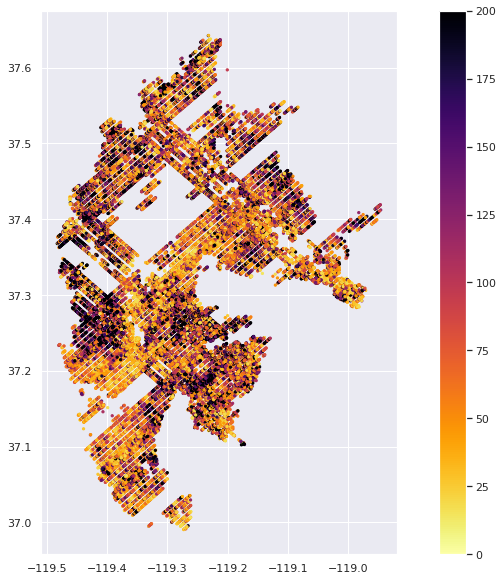

In [48]:
fig, ax = plt.subplots(figsize=(15,10))

gedi_creek_before[gedi_creek_before.pft_class==1].plot(column='agbd', ax=ax, legend=True, vmin=0, vmax=200, markersize=5, cmap='inferno_r')

<AxesSubplot: >

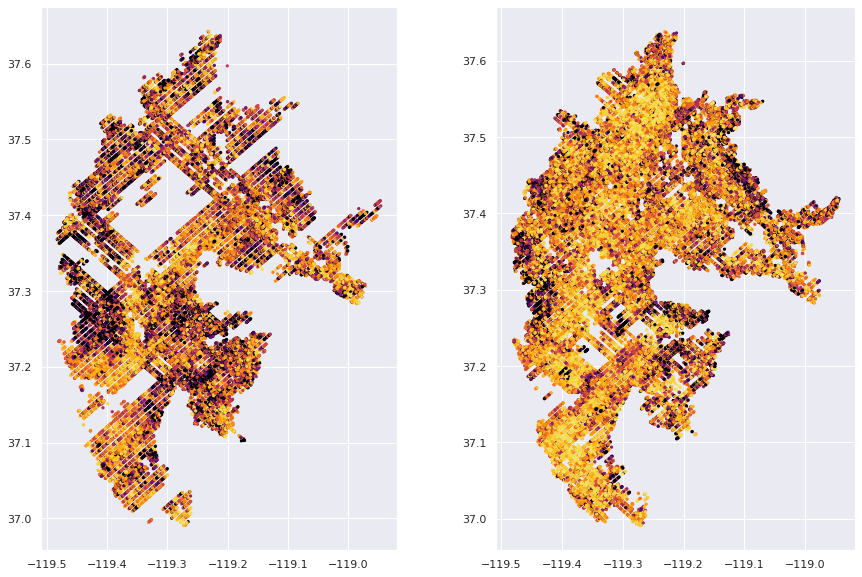

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))

gedi_creek_before[gedi_creek_before.pft_class==1].plot(column='agbd', ax=ax[0], vmin=0, vmax=200, markersize=5, cmap='inferno_r')

gedi_creek_after[gedi_creek_after.pft_class==1].plot(column='agbd', ax=ax[1], legend=False, vmin=0, vmax=200, markersize=5, cmap='inferno_r')

## North Complex Fire

In [ ]:
north_complex = sierra_fire_perimeters[sierra_fire_perimeters.FIRE_NAME=='NORTH COMPLEX'].overlay(sierras, how="union")
north_complex.plot(cmap='tab20b')

In [ ]:
sierra_fire_perimeters[sierra_fire_perimeters.FIRE_NAME=='NORTH COMPLEX'].geometry.explore()

## Caldor Fire

In [ ]:
caldor = sierra_fire_perimeters[sierra_fire_perimeters.FIRE_NAME=='CALDOR'].overlay(sierras, how="union")
caldor.plot(cmap='tab20b')

In [ ]:
sierra_fire_perimeters[sierra_fire_perimeters.FIRE_NAME=='CALDOR'].geometry.explore()

## Castle Fire

In [ ]:
castle = sierra_fire_perimeters[sierra_fire_perimeters.FIRE_NAME=='CASTLE'].overlay(sierras, how="union")
castle.plot(cmap='tab20b')

In [ ]:
sierra_fire_perimeters[sierra_fire_perimeters.FIRE_NAME=='CASTLE'].geometry.explore()

In [ ]:
# Let's examine the data visually for correctness. First, let's plot dnbr6 raster by itself.
from rasterio.plot import show as show_raster
f, ax = plt.subplots()

raster_dnbr6 = rio.open('/maps/fire-regen/data/rasters/CREEK/creek_dnbr6.tiff')

show_raster((raster_dnbr6, 1), ax=ax, cmap='inferno_r', vmin=1, vmax=6)
#raster_test_reprojected.plot.imshow(ax=ax, cmap="inferno", vmin=0, vmax=5)
#plt.imshow(raster_test.read(1), cmap='pink', ax=ax)
#creek.plot(ax=ax, alpha=0.5)

plt.show()